In [ ]:
# !pip uninstall tensorflow==2.16.1

In [ ]:
# !pip install --upgrade tensorflow

In [ ]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    auc,
)

from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate
import pydot
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import math
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# CLEAN_DATA_FOLDER = "/content/drive/MyDrive/GWAR/All_files/"
# MODEL_DATA_FOLDER = "/content/drive/MyDrive/GWAR/All_files/Model"

import os

# Define data folders
CLEAN_DATA_FOLDER = "C:/Users/pmgan/Downloads/project/New folder/"
MODEL_DATA_FOLDER = "C:/Users/pmgan/Downloads/project/New folder/MODEL/"

# List files in CLEAN_DATA_FOLDER
clean_files = os.listdir(CLEAN_DATA_FOLDER)
print("Files in CLEAN_DATA_FOLDER:", clean_files)

# List files in MODEL_DATA_FOLDER
model_files = os.listdir(MODEL_DATA_FOLDER)
print("Files in MODEL_DATA_FOLDER:", model_files)

# # Example: Load a file from CLEAN_DATA_FOLDER
# import pandas as pd

# # Replace 'example.csv' with your actual file name
# file_path = os.path.join(CLEAN_DATA_FOLDER, 'example.csv')
# data = pd.read_csv(file_path)

# # Display the first few rows of the dataframe
# data.head()


Files in CLEAN_DATA_FOLDER: ['.ipynb_checkpoints', 'FINAL_GRU_glove.ipynb', 'glove.100d.embeddings.npy', 'Model', 'test.tsv', 'train_final.tsv']
Files in MODEL_DATA_FOLDER: ['GPU_model_glove.png', 'gru_glove_finalmodel.keras']


In [ ]:
# Load and prepare training data
train_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER,"train_final.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    }
)

# Convert lists into train TensorFlow ragged tensors
train_X_0 = tf.ragged.constant(train_df["question1"].tolist())
train_X_1 = tf.ragged.constant(train_df["question2"].tolist())
train_Y = tf.ragged.constant(train_df["is_duplicate"].tolist(), dtype=tf.float32)

In [ ]:
train_df.shape

(435399, 4)

In [ ]:
test_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "test.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    }
)

# Convert lists into test TensorFlow ragged tensors
test_X_0 = tf.ragged.constant(test_df["question1"].tolist())
test_X_1 = tf.ragged.constant(test_df["question2"].tolist())
test_Y = tf.ragged.constant(test_df["is_duplicate"].tolist(), dtype=tf.float32)

In [ ]:
# validation_df = pd.read_csv(
#     os.path.join(CLEAN_DATA_FOLDER, "validation.tsv"),
#     sep="\t",
#     converters={
#         "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#         "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#     },
# )
# # Convert lists into validation TensorFlow ragged tensors
# validation_X_0 = tf.ragged.constant(validation_df["question1"].tolist())
# validation_X_1 = tf.ragged.constant(validation_df["question2"].tolist())
# validation_Y = tf.ragged.constant(validation_df["is_duplicate"].tolist(), dtype=tf.float32)

In [ ]:
# Setting best or common parameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 50

In [ ]:
# Function to pad inputs for uniformity
def pad_inputs(inputs, outputs):
    return (
        (inputs[0].to_tensor(default_value=0), inputs[1].to_tensor(default_value=0)),
        tf.expand_dims(outputs, axis=-1),
    )

def get_embedding_layer(embed_name="glove", embed_dim=100):
    embedding_matrix = np.load(os.path.join(CLEAN_DATA_FOLDER, f"{embed_name}.{embed_dim}d.embeddings.npy"))
    embedding_layer = keras.layers.Embedding(embedding_matrix.shape[0], embed_dim, name=f"{embed_name}")
    embedding_layer.build((1,))
    embedding_layer.trainable = False
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

In [ ]:
# Prepare dataset for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices(((train_X_0, train_X_1), train_Y))
train_dataset = train_dataset.shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

# validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_X_0, validation_X_1), validation_Y))
# validation_dataset = validation_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((test_X_0, test_X_1), test_Y))
test_dataset = test_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Model creation function for GRU
def create_gru_model(embed_name="glove", embed_dim=100):
    question1 = Input(shape=(None,), dtype='int32', name="question1")
    question2 = Input(shape=(None,), dtype='int32', name="question2")

    embedding_layer = get_embedding_layer(embed_name, embed_dim)

    q1_embed = embedding_layer(question1)
    q2_embed = embedding_layer(question2)

    gru_layer = keras.layers.GRU(128, return_sequences=False)
    q1_encoded = gru_layer(q1_embed)
    q2_encoded = gru_layer(q2_embed)

    concatenated = keras.layers.concatenate([q1_encoded, q2_encoded])
    dense1 = keras.layers.Dense(64, activation='relu')(concatenated)
    output = keras.layers.Dense(1, activation='sigmoid')(dense1)

    model = keras.Model(inputs=[question1, question2], outputs=output)
    return model

# Create GRU model
model = create_gru_model("glove", 100)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 question1 (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 question2 (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 glove (Embedding)           (None, None, 100)            1128020   ['question1[0][0]',           
                                                          0          'question2[0][0]']           
                                                                                                  
 gru (GRU)                   (None, 128)                  88320     ['glove[0][0]',          

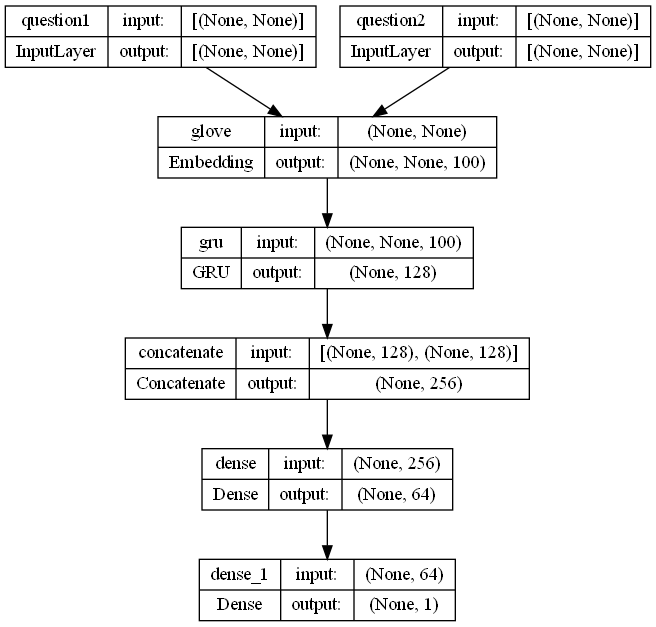

In [ ]:
keras.utils.plot_model(
    model,
    to_file=os.path.join(MODEL_DATA_FOLDER, "GPU_model_glove.png"),
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
# Model compilation
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

# Model training
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True)]
)

# Saving the model
model.save(os.path.join(MODEL_DATA_FOLDER, "gru_glove_finalmodel.keras"))

Epoch 1/50

6804/6804 [==============================] - 128s 18ms/step - loss: 0.4997 - binary_accuracy: 0.7457 - auc: 0.8310 - val_loss: 0.4848 - val_binary_accuracy: 0.7685 - val_auc: 0.8396
Epoch 2/50
6804/6804 [==============================] - 130s 19ms/step - loss: 0.4172 - binary_accuracy: 0.7997 - auc: 0.8880 - val_loss: 0.4486 - val_binary_accuracy: 0.7812 - val_auc: 0.8609
Epoch 3/50
6804/6804 [==============================] - 132s 19ms/step - loss: 0.3753 - binary_accuracy: 0.8248 - auc: 0.9110 - val_loss: 0.4258 - val_binary_accuracy: 0.7993 - val_auc: 0.8767
Epoch 4/50
6804/6804 [==============================] - 133s 19ms/step - loss: 0.3432 - binary_accuracy: 0.8426 - auc: 0.9263 - val_loss: 0.4299 - val_binary_accuracy: 0.8045 - val_auc: 0.8811
Epoch 5/50
6804/6804 [==============================] - 137s 20ms/step - loss: 0.3197 - binary_accuracy: 0.8548 - auc: 0.9363 - val_loss: 0.4163 - val_binary_accuracy: 0.8082 - val_auc: 0.8876
Epoch 6/50
6804/6804 [============

In [ ]:

class QuoraQuestionPairDataset(tf.keras.utils.Sequence):
    def __init__(self, x, y, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.x = x
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.y) / self.batch_size)

    def __getitem__(self, idx):
        batch_x_0 = self.x[0][idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x_1 = self.x[1][idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x_0 = keras.utils.pad_sequences(batch_x_0, padding='post')
        batch_x_1 = keras.utils.pad_sequences(batch_x_1, padding='post')
        batch_y = np.expand_dims(np.asarray(batch_y), axis=-1)
        return (batch_x_0, batch_x_1), batch_y

Data Structure to store metrics

In [ ]:
test_metrics = {
    "Accuracy": {},
    "Precision": {},
    "Recall": {},
    "F1": {},
    "ROC AUC": {},
    "PR AUC": {}
}

In [ ]:
model.load_weights(os.path.join(MODEL_DATA_FOLDER, "gru_glove_finalmodel.keras"))

In [ ]:
model_name = "GRU (glove)"

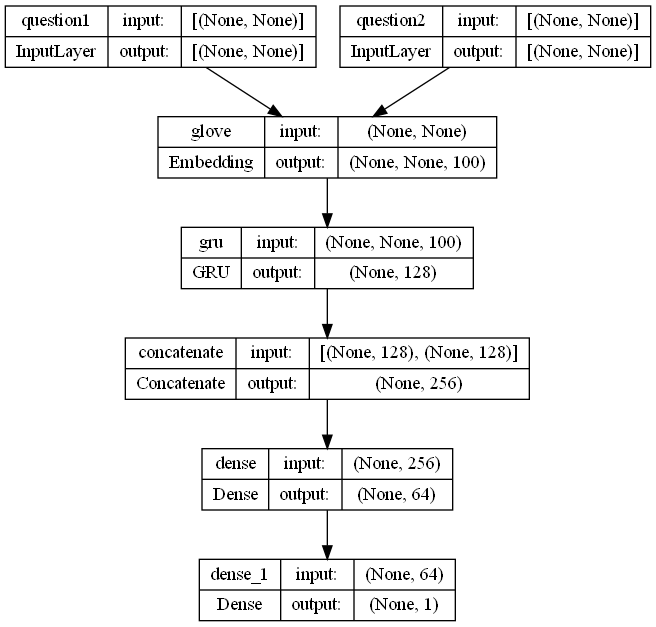

In [ ]:
keras.utils.plot_model(
    model,
    to_file=os.path.join(MODEL_DATA_FOLDER, f"test_model.png"),
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
# validation_df = pd.read_csv(
#     os.path.join(CLEAN_DATA_FOLDER, "validation.tsv"),
#     sep="\t",
#     converters={
#         "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#         "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#     },
# )
# validation_dataset = QuoraQuestionPairDataset(
#     x=(validation_df["question1"].tolist(), validation_df["question2"].tolist()),
#     y=validation_df["is_duplicate"].tolist(),
#     batch_size=256,
# )
# validation_y_pred = model.predict(validation_dataset)
# validation_results_df = pd.DataFrame(
#     {
#         "y_true": validation_df["is_duplicate"].tolist(),
#         "y_pred": validation_y_pred.round().astype(int).squeeze().tolist(),
#         "y_score": validation_y_pred.squeeze().tolist(),
#     }
# )

In [ ]:
test_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "test.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    },
)
test_dataset = QuoraQuestionPairDataset(
    x=(test_df["question1"].tolist(), test_df["question2"].tolist()),
    y=test_df["is_duplicate"].tolist(),
    batch_size=256,
)
test_y_pred = model.predict(test_dataset)
test_results_df = pd.DataFrame(
    {
        "y_true": test_df["is_duplicate"].tolist(),
        "y_pred": test_y_pred.round().astype(int).squeeze().tolist(),
        "y_score": test_y_pred.squeeze().tolist(),
    }
)

158/158 [==============================] - 6s 32ms/step


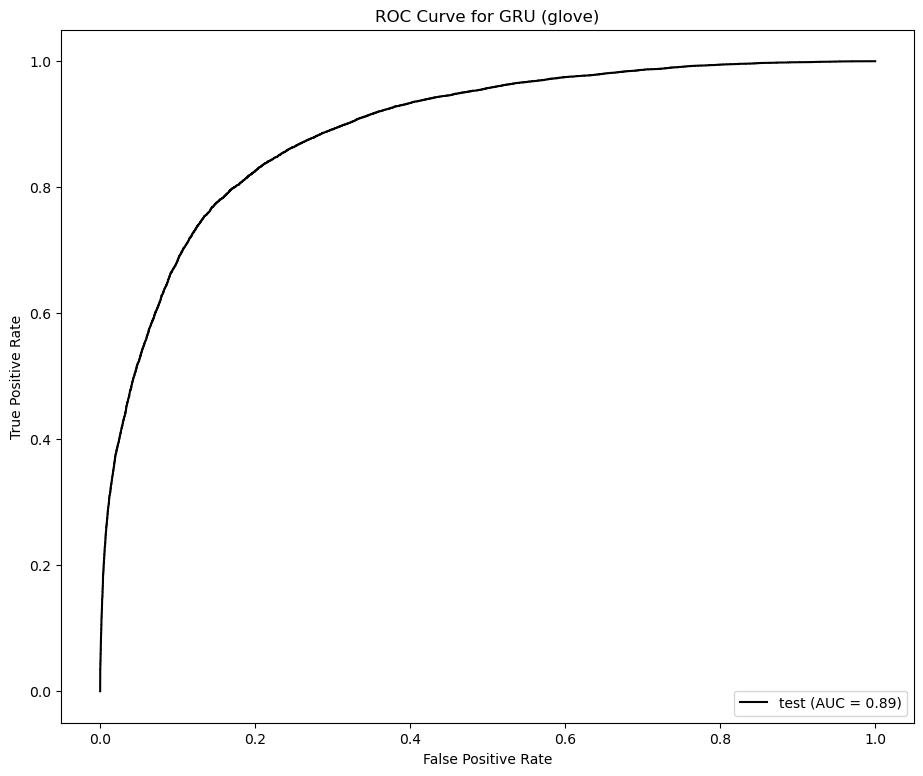

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(11, 9))
ax.set_title(f"ROC Curve for {model_name}")
fpr, tpr, thresholds = roc_curve(
    test_results_df["y_true"], test_results_df["y_score"], pos_label=1
)
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name="test"
)
_ = display.plot(ax=ax, color="black")

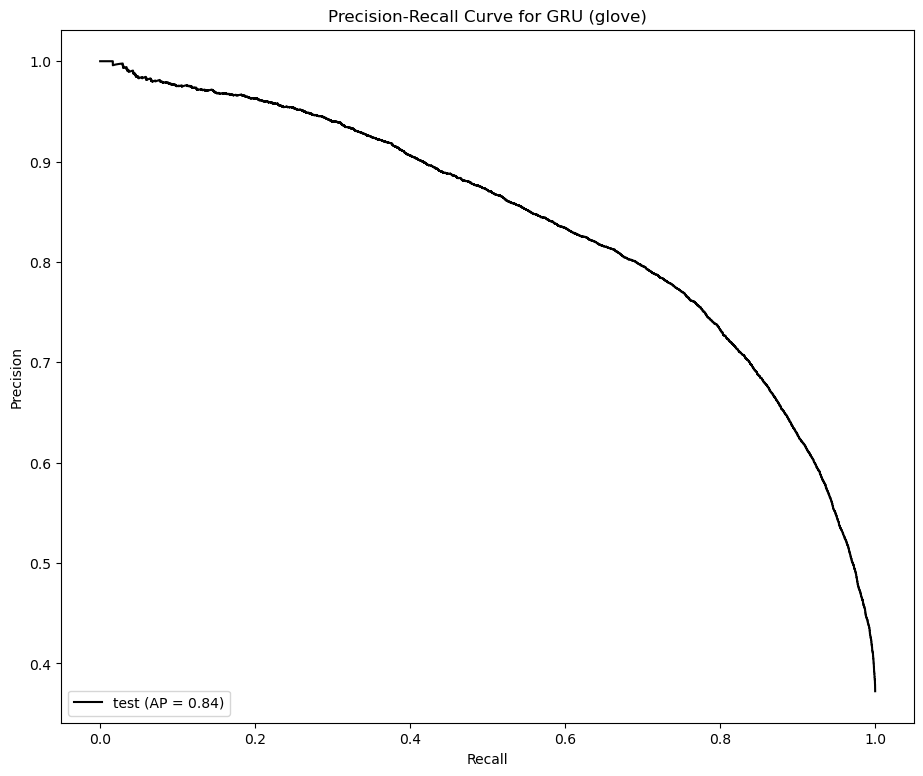

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(11, 9))
ax.set_title(f"Precision-Recall Curve for {model_name}")
precision, recall, _ = precision_recall_curve(
    test_results_df["y_true"], test_results_df["y_score"], pos_label=1
)
display = PrecisionRecallDisplay(
    precision=precision,
    recall=recall,
    average_precision=average_precision_score(
        test_results_df["y_true"], test_results_df["y_score"]
    ),
    estimator_name="test",
)
_ = display.plot(ax=ax, color="black")

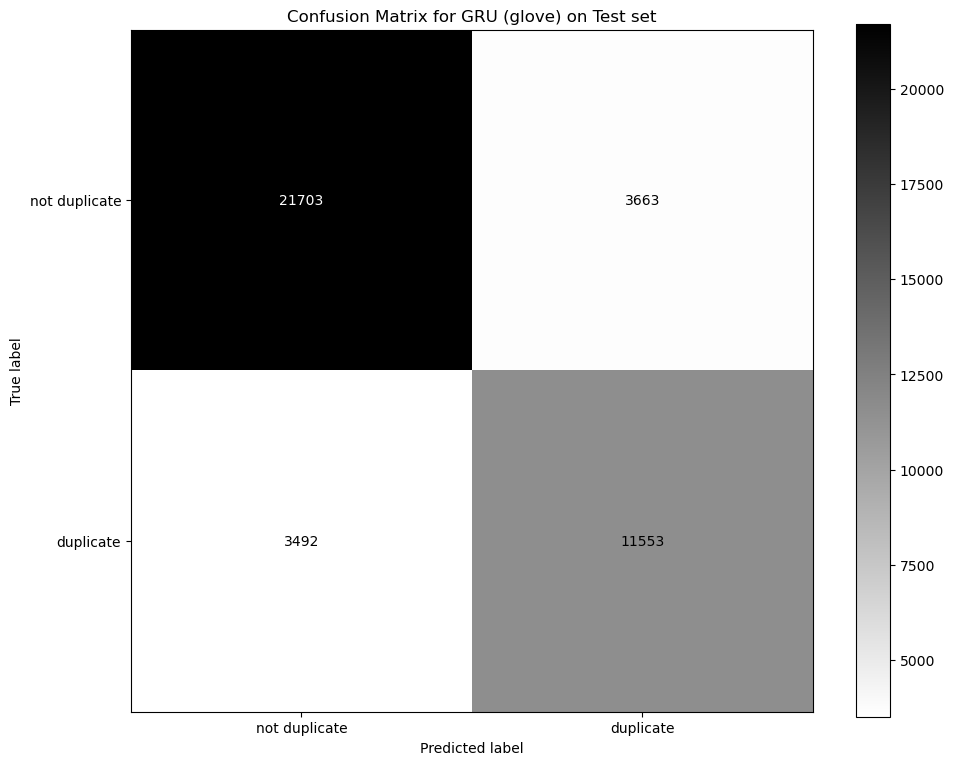

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(11, 9))
ax.set_title(f"Confusion Matrix for {model_name} on Test set")
display = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        test_results_df["y_true"], test_results_df["y_pred"]
    ),
    display_labels=("not duplicate", "duplicate"),
)
_ = display.plot(ax=ax, cmap="binary")

In [ ]:
accuracy = accuracy_score(test_results_df["y_true"], test_results_df["y_pred"])
precision = precision_score(test_results_df["y_true"], test_results_df["y_pred"])
recall = recall_score(test_results_df["y_true"], test_results_df["y_pred"])
f1 = f1_score(test_results_df["y_true"], test_results_df["y_pred"])
auc_roc = roc_auc_score(test_results_df["y_true"], test_results_df["y_score"])
pr, re, _ = precision_recall_curve(
    test_results_df["y_true"], test_results_df["y_score"], pos_label=1
)
auc_pr = auc(re, pr)
test_metrics["Accuracy"][model_name] = accuracy
test_metrics["Precision"][model_name] = precision
test_metrics["Recall"][model_name] = recall
test_metrics["F1"][model_name] = f1
test_metrics["ROC AUC"][model_name] = auc_roc
test_metrics["PR AUC"][model_name] = auc_pr
pd.DataFrame(test_metrics)
pd.DataFrame(test_metrics).to_csv("temp_results.csv", index_label="Model")
pd.DataFrame(test_metrics)

,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC
GRU (glove),0.822944,0.759267,0.767896,0.763557,0.891904,0.83806
